# Лабораторная работа 1: Машина опорных векторов (SVM)

<img src="svm_img.png" width=350>

Результат лабораторной работы — **отчет** в формате ноутбуков IPython (ipynb-файл). Нам не интересен ваш код. Чем меньше кода, тем лучше всем: нам — меньше проверять, вам — проще найти ошибку или дополнить эксперимент.

Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Ответы на вопросы должны быть полными, четкими и хорошо аргументированными.

## 1. Квадратичное программирование и QP-солвер

Квадратичное программирование (QP) — специальный тип задач математической оптимизации, заключающийся в нахождении точки минимума неотрицательно-определенной квадратичной формы (многомерная парабола) в присутствии линейных ограничений:
$$
\begin{gather}
    \frac{1}{2}\boldsymbol x^T\boldsymbol P\boldsymbol x + \boldsymbol q^T\boldsymbol x \to \min_{\boldsymbol x} \\
    \begin{aligned}
        \text{s.t.} \quad & \boldsymbol G\boldsymbol x \le \boldsymbol h \\
        & \boldsymbol A\boldsymbol x = \boldsymbol b
    \end{aligned}
\end{gather}
$$

Здесь $\boldsymbol P$ — симметричная матрица. В ограничениях $\boldsymbol G\boldsymbol x \le \boldsymbol h$ и $\boldsymbol A\boldsymbol x = \boldsymbol b$ под знаками равенства и неравенства подразумевается сравнение всех компонент векторов.

Задача квадратичного программирования хорошо изучена, существуют эффективные алгоритмы для ее решения. Имеется множество библиотек с солверами для задачи QP, вот некоторые из них:
 - [CVXOPT](http://cvxopt.org/) (свободно-распространяемая, Python) **рекомендуется к использованию**
 - [Mosek](https://www.mosek.com/) (коммерческая с возможностью получения академической лицензии, C, Java, MATLAB, .NET, R, Python)
 - [Matlab Optimization Toolbox](http://www.mathworks.com/help/optim/ug/quadprog.html) 

#### Задание

1. Установите QP-солвер, разберитесь с его интерфейсом.
2. Протестируйте солвер, решив простую задачу оптимизации в двумерном пространстве:
$$f(\boldsymbol x) = -8x_1 - 16x_2 + x_1^2 + 4x_2^2, \quad \text{s.t.:} \; x_1 + x_2 \leq 5, \; 0 \leq x_1 \leq 3, \; x_2 \geq 0$$
3. Какие из ограничений-неравенств задачи являются _активными_, т.е. влияют на точку оптимума, а какие ограничения можно выбросить и точка оптимума не поменяется?

In [7]:
import numpy
from cvxopt import matrix
from cvxopt import solvers

P = matrix(numpy.diag(([2,8])), tc='d')
q = matrix(numpy.array([-8,-16]), tc='d')
G = matrix(numpy.array([[1,1],[-1,0],[1,0],[0,-1]]), tc='d')
h = matrix(numpy.array([5,0,3,0]), tc='d')


sol = solvers.qp(P,q,G,h)

print(sol['x'] )

     pcost       dcost       gap    pres   dres
 0: -3.0512e+01 -3.8829e+01  8e+00  0e+00  2e-01
 1: -3.0792e+01 -3.1146e+01  4e-01  2e-16  5e-03
 2: -3.0982e+01 -3.1024e+01  4e-02  1e-16  4e-04
 3: -3.0997e+01 -3.1003e+01  6e-03  2e-16  5e-17
 4: -3.1000e+01 -3.1000e+01  7e-04  2e-16  3e-17
 5: -3.1000e+01 -3.1000e+01  1e-04  2e-16  4e-17
 6: -3.1000e+01 -3.1000e+01  1e-05  2e-16  3e-17
Optimal solution found.
[ 3.00e+00]
[ 2.00e+00]



## 2. Линейный SVM

Рассмотрим задачу бинарной классификации. Будем обозначать обучающую выборку $\{(\boldsymbol x_n, y_n)\}_{n=1}^N$, где $N$ — количество объектов, $\boldsymbol x_n \in \mathbb{R}^d$ — числовой вектор признакового описания объекта, $y_n \in \{+1, -1\}$ — класс объекта.

Машина опорных векторов обучает модель разделяющей гиперплоскости:
$$f(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + b$$
Параметры модели — вектор весов $\boldsymbol w \in \mathbb{R}^d$ и сдвиг $b \in \mathbb{R}$.

Обучение модели происходит путем решения оптимизационной задачи:
$$
\begin{gather}
    \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \to \min_{\boldsymbol w, \boldsymbol \xi, b} \\
    \text{s.t.: } \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1 - \xi_n, \quad \xi_n \geq 0, \quad \forall n=1,\dots,N
\end{gather}
$$

Ограничения вида $\quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1$ требуют, чтобы объекты правильно классифицировались разделяющей гиперплоскостью. Поскольку линейная разделимость выборки не гарантируется на практике, вводят переменные $\xi_n$ (slack variables), которые ослабляют ограничения правильной классификации. В оптимизируемом функционале слагаемое $\| \boldsymbol w \|^2$ штрафует малую ширину разделяющей гиперплоскости, сумма $\sum_n \xi_n$ штрафует ослабление ограничений. 

Гиперпараметр $C$ задает баланс между шириной разделяющей полосы и ошибками, допускаемыми классификатором. Обратите внимание, что $C$ фиксируется до обучения и не оптимизируется вместе с параметрами модели.

Гиперпараметр $C$ отвечает за обобщающую способность разделяющей гиперплоскости, высокая обобщающая способность (соотвествующая большому значению $C$) может привести к переобучению, если линейная модель хорошо описывает обучающие примеры. При подборе оптимального параметра $C$ необходимо оценивать качество на отложенной выборке или кросс-валидации. Как правило, для конкретной задачи заранее неизвестно, какой порядок имеет оптимальное значение гиперпараметра $C$, поэтому перебирать значения лучше по логарифмической сетке, например: $10^{-3}, 10^{-2}, \dots, 10^{5}$.

После нахождения решения оптимизационной задачи $(\boldsymbol w_{\star}, \boldsymbol \xi_{\star}, b_{\star})$, часть ограничений становятся _активными_, т.е. переходят в "крайнее положение" — точное равенство:
$$\quad y_n (\boldsymbol w_{\star}^T \boldsymbol x_n + b_{\star}) = 1 - \xi_{\star,n}$$
Объекты, соответствующие активным ограничениям называются _опорными_.

#### Явное преобразование признаков

Разделяющая гиперплоскость — достаточно грубая модель, редко данные могут быть описаны линейной моделью. Линейная неразделимость векторов может быть исправлена путем перехода в другое признаковое пространство, в котором линейная модель лучше описывает данные и, возможно, существует правильно классифицирующая разделяющая гиперплоскость:

$$\boldsymbol x \in \mathbb{R}^d \mapsto \phi(\boldsymbol x) \in \mathbb{R}^t$$

Так, например, добавление всех попарных произведений признаков: $\phi(x_1, \dots, x_d) = (x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2)$ переводит в пространство, в котором линейная гиперплоскость является квадратичной формой в исходном пространстве и в исходном пространстве признаков разделяющая поверхность может быть, скажем, эллипсом.

[Видеоролик с демонстрацией](https://youtu.be/9NrALgHFwTo)

#### Задание
  1. Сведите задачу обучения линейного SVM к QP, реализуйте процедуру обучения Линейного SVM при помощи QP-солвера.
  2. Сгенерируйте три случайные двумерные выборки для бинарной классификации:
    - с линейно-разделимыми классами
    - с хорошо разделимыми классами, но не линейно
    - с плохо разделимыми классами по имеющимся признакам
  3. Протестируйте линейный SVM на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Постройте классификаторы с различным значением параметра $C$.
  4. Как зависит число опорных векторов от параметра $C$ для различных выборок?
  5. Используя явное преобразование признаков обучите методом опорных векторов квадратичную разделяющую поверхность. Покажите ее на плоскости.

In [1]:
import numpy as np
from cvxopt import matrix, solvers

def linear_svm(X, y, C):
    #定义一个线性支持向量机 (SVM) 的函数，输入参数为特征矩阵 X、标签向量 y 和正则化参数 C。
    N, d = X.shape
    #获取特征矩阵 X 的形状，N 表示样本数量，d 表示特征维度。
    
    # 构建目标函数矩阵和向量
    #块矩阵
    P = matrix(np.block([[np.eye(d), np.zeros((d, 1)), np.zeros((d, N))],
                         [np.zeros((1, d)), 0, np.zeros((1, N))],
                         [np.zeros((N, d)), np.zeros((N, 1)), np.zeros((N, N))]]))
    #水平堆叠数组
    q = matrix(np.hstack([np.zeros(d + 1), C * np.ones(N)]))

    # 构建不等式约束矩阵和向量
    G = matrix(np.vstack([-np.hstack([X, y.reshape(-1, 1), np.eye(N)]),
                          np.hstack([np.zeros((N, d + 1)), -np.eye(N)])]))
    h = matrix(np.hstack([-np.ones(N), np.zeros(N)]))

    # 求解QP问题
    #提取解向量 z 并展平为一维数组。
    sol = solvers.qp(P, q, G, h)
    z = np.array(sol['x']).flatten()

    w = z[:d]
    #d 是特征矩阵 X 的特征维度。在 z 中，前 d 个元素对应于权重向量 w。
    #示例：假设 d = 2，z = [1.5, 2.0, 0.5, 0.1, 0.2, 0.3]，那么 w = [1.5, 2.0]。
    b = z[d]
    #在 z 中，第 d + 1 个元素对应于偏置项 b
    xi = z[d+1:]
    #在 z 中，从第 d + 2 个元素到最后的所有元素对应于松弛变量 xi。松弛变量 xi 用于处理那些不能完全被超平面正确分类的样本。

    return w, b, xi

# 示例数据
X = np.array([[1, 2], [2, 3], [3, 1], [4, 2]])
y = np.array([1, 1, -1, -1])
C = 1.0

w, b, xi = linear_svm(X, y, C)
print("w:", w)
print("b:", b)
print("xi:", xi)

     pcost       dcost       gap    pres   dres
 0: -3.4841e+00  4.6270e+00  2e+01  3e+00  7e+00
 1:  1.6469e+00 -1.8337e-01  2e+00  6e-02  2e-01
 2:  1.7202e-01  6.4280e-02  1e-01  2e-03  4e-03
 3:  8.5048e-02  7.9033e-02  6e-03  1e-05  3e-05
 4:  8.0050e-02  7.9985e-02  7e-05  1e-07  3e-07
 5:  8.0000e-02  8.0000e-02  7e-07  1e-09  3e-09
 6:  8.0000e-02  8.0000e-02  7e-09  1e-11  3e-11
Optimal solution found.
w: [0.32000001 0.24000001]
b: 0.20000000533061876
xi: [5.73241060e-11 8.85881071e-11 5.73241060e-11 8.85881071e-11]


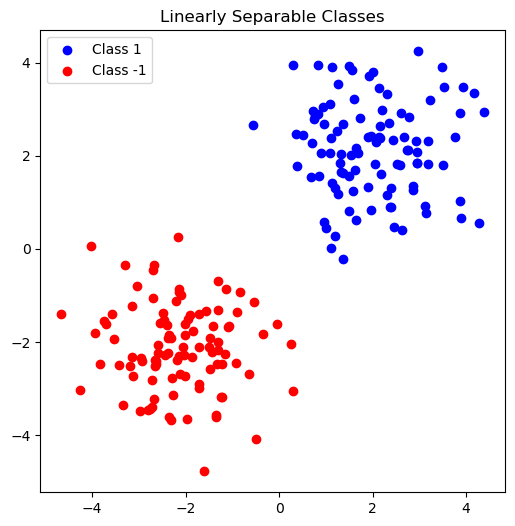

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# 生成线性可分的数据集
np.random.seed(0)
X1_linear = np.random.multivariate_normal([2, 2], [[1, 0], [0, 1]], 100)
#生成 100 个二维高斯分布的样本点，均值为 [2, 2]，协方差矩阵为 [[1, 0], [0, 1]]。这些样本点属于第一类。
X2_linear = np.random.multivariate_normal([-2, -2], [[1, 0], [0, 1]], 100)
#生成 100 个二维高斯分布的样本点，均值为 [-2, -2]，协方差矩阵为 [[1, 0], [0, 1]]。这些样本点属于第二类。
y1_linear = np.ones(100)
#生成 100 个标签为 1 的数组，表示第一类的标签。
y2_linear = -np.ones(100)
#生成 100 个标签为 -1 的数组，表示第二类的标签。

X_linear = np.vstack((X1_linear, X2_linear))
#将两个类别的特征矩阵垂直堆叠在一起，形成一个 200 x 2 的特征矩阵 X_linear。
y_linear = np.hstack((y1_linear, y2_linear))
#将两个类别的标签水平堆叠在一起，形成一个 200 维的标签向量 y_linear。

plt.figure(figsize=(6, 6))
plt.scatter(X1_linear[:, 0], X1_linear[:, 1], c='blue', label='Class 1')
#X1_linear[:, 0]：这是 X1_linear 矩阵的第一列，表示第一类样本点的 x 坐标。
#X1_linear[:, 1]：这是 X1_linear 矩阵的第二列，表示第一类样本点的 y 坐标。
plt.scatter(X2_linear[:, 0], X2_linear[:, 1], c='red', label='Class -1')
plt.title('Linearly Separable Classes')
plt.legend()
plt.show()

In [21]:
print("X1_linear:")
print(X1_linear[:10])
print("X2_linear:")
print(X2_linear[:10])

X1_linear:
[[3.76405235 2.40015721]
 [2.97873798 4.2408932 ]
 [3.86755799 1.02272212]
 [2.95008842 1.84864279]
 [1.89678115 2.4105985 ]
 [2.14404357 3.45427351]
 [2.76103773 2.12167502]
 [2.44386323 2.33367433]
 [3.49407907 1.79484174]
 [2.3130677  1.14590426]]
X2_linear:
[[-2.36918184 -2.23937918]
 [-0.9003404  -1.34473627]
 [-1.35986847 -3.61695604]
 [-2.02432612 -2.73803091]
 [-1.7200754  -2.09815039]
 [-1.08982109 -1.68278178]
 [-1.21367204 -2.4664191 ]
 [-2.94444626 -2.41004969]
 [-2.01702041 -1.62084826]
 [ 0.25930895 -2.04225715]]


D:\Anaconda\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


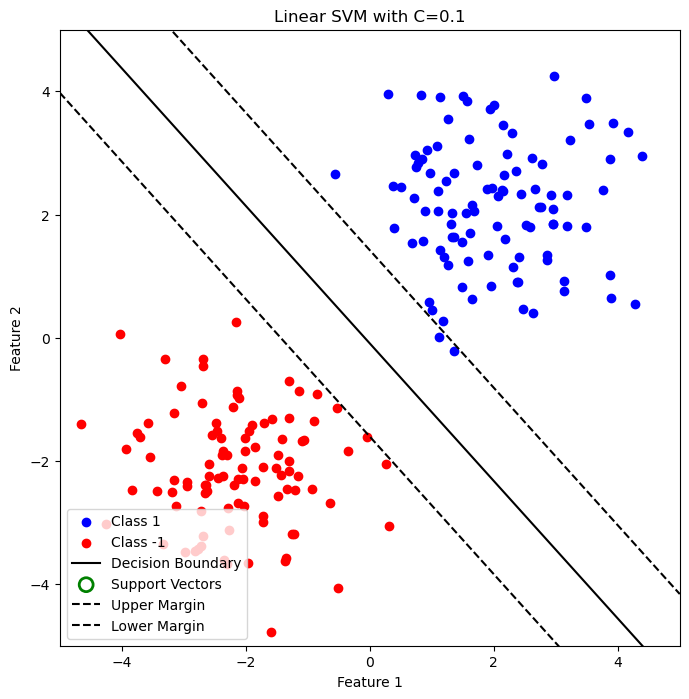

D:\Anaconda\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


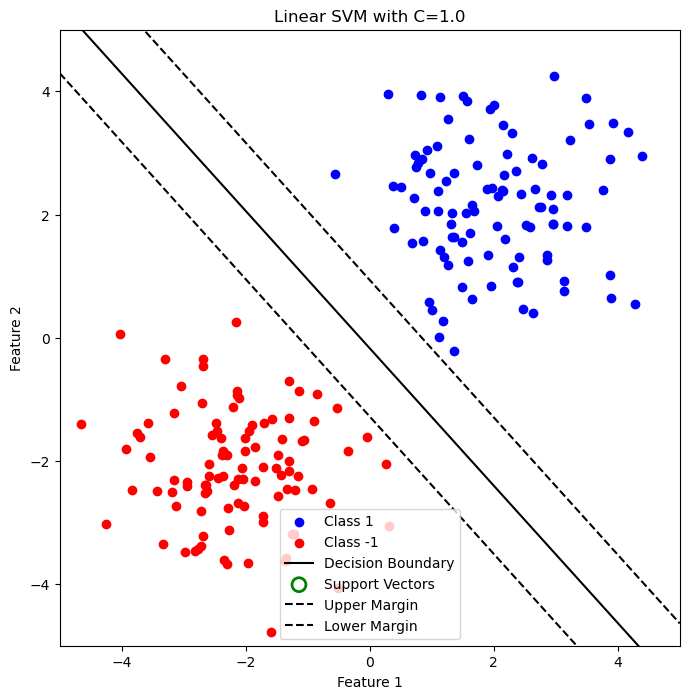

D:\Anaconda\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


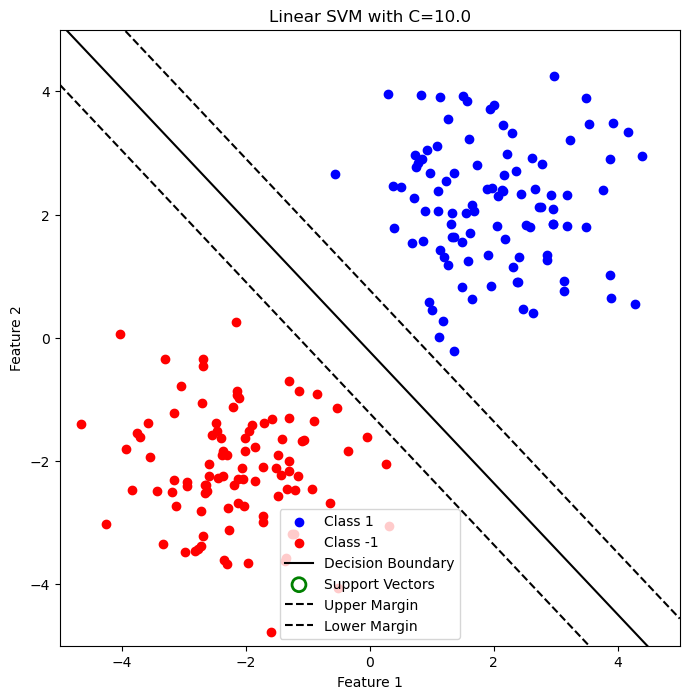

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 linear_svm 函数已经实现
def linear_svm(X, y, C):
    # 这里假设 linear_svm 函数返回 w, b, xi
    # 你可以根据实际情况实现或调用现有的 SVM 库
    from sklearn.svm import LinearSVC
    model = LinearSVC(C=C, max_iter=10000)
    model.fit(X, y)
    w = model.coef_[0]
    b = model.intercept_[0]
    xi = None  # 如果需要计算松弛变量，可以在这里实现
    return w, b, xi

# 测试线性 SVM 并显示结果
def test_linear_svm(X, y, C):
    # 绘制数据集
    plt.figure(figsize=(8, 8))
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Class 1')
    plt.scatter(X[y == -1, 0], X[y == -1, 1], c='red', label='Class -1')
    
    w, b, xi = linear_svm(X, y, C)

    # 计算决策边界和支持向量
    decision_boundary_x = np.linspace(-5, 5, 100)
    decision_boundary_y = -(w[0] * decision_boundary_x + b) / w[1]

    # 计算支持向量
    support_vectors = X[np.abs(y * (X.dot(w) + b) - 1) < 1e-5]

    # 绘制决策边界
    plt.plot(decision_boundary_x, decision_boundary_y, 'k-', label='Decision Boundary')

    # 绘制支持向量
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, facecolors='none', edgecolors='green', linewidth=2, label='Support Vectors')

    # 绘制限制走廊的水平线
    margin = 1 / np.linalg.norm(w)
    upper_margin = decision_boundary_y + margin
    lower_margin = decision_boundary_y - margin
    plt.plot(decision_boundary_x, upper_margin, 'k--', label='Upper Margin')
    plt.plot(decision_boundary_x, lower_margin, 'k--', label='Lower Margin')

    # 设置绘图范围
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)

    plt.title(f'Linear SVM with C={C}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

# 测试不同参数值 C 的分类器
Cs = [0.1, 1.0, 10.0]
for C in Cs:
    test_linear_svm(X_linear, y_linear, C)

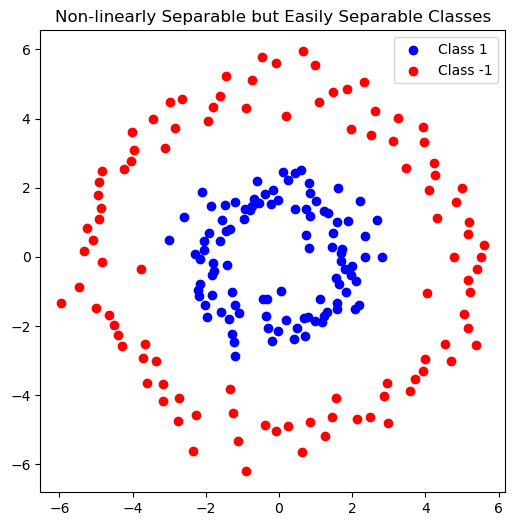

In [7]:
# 生成非线性可分但容易分离的数据集
np.random.seed(1)
theta = np.linspace(0, 2 * np.pi, 100)
#theta = np.linspace(0, 2 * np.pi, 100)：生成从 0 到 2 * pi 的 100 个等间距的点，表示角度
r1 = 2 + 0.5 * np.random.randn(100)
#生成 100 个半径值，均值为 2，标准差为 0.5。这些半径值用于生成第一类的样本点。
r2 = 5 + 0.5 * np.random.randn(100)
#生成 100 个半径值，均值为 5，标准差为 0.5。这些半径值用于生成第二类的样本点。

#生成特征矩阵
X1_nonlinear = np.column_stack((r1 * np.cos(theta), r1 * np.sin(theta)))
#将 r1 和 theta 转换为笛卡尔坐标系下的点，生成第一类的特征矩阵 X1_nonlinear。
#r1 * cos(theta)，得到对应的 x 坐标。
#r1 * sin(theta)，得到对应的 y 坐标。
#两个数组按列堆叠在一起，形成一个二维数组。
X2_nonlinear = np.column_stack((r2 * np.cos(theta), r2 * np.sin(theta)))
#生成标签向量
y1_nonlinear = np.ones(100)
#生成 100 个标签为 1 的数组，表示第一类的标签。
y2_nonlinear = -np.ones(100)

X_nonlinear = np.vstack((X1_nonlinear, X2_nonlinear))
y_nonlinear = np.hstack((y1_nonlinear, y2_nonlinear))

plt.figure(figsize=(6, 6))
plt.scatter(X1_nonlinear[:, 0], X1_nonlinear[:, 1], c='blue', label='Class 1')
plt.scatter(X2_nonlinear[:, 0], X2_nonlinear[:, 1], c='red', label='Class -1')
plt.title('Non-linearly Separable but Easily Separable Classes')
plt.legend()
plt.show()

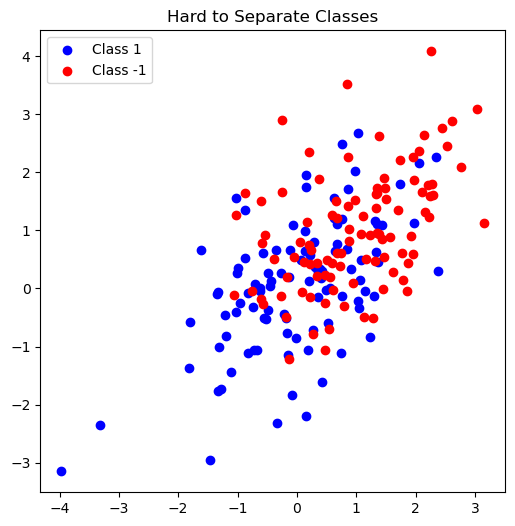

In [19]:
# 生成难以分离的数据集
np.random.seed(2)
X1_hard = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], 100)
X2_hard = np.random.multivariate_normal([1, 1], [[1, 0.5], [0.5, 1]], 100)
y1_hard = np.ones(100)
y2_hard = -np.ones(100)

X_hard = np.vstack((X1_hard, X2_hard))
y_hard = np.hstack((y1_hard, y2_hard))

plt.figure(figsize=(6, 6))
plt.scatter(X1_hard[:, 0], X1_hard[:, 1], c='blue', label='Class 1')
plt.scatter(X2_hard[:, 0], X2_hard[:, 1], c='red', label='Class -1')
plt.title('Hard to Separate Classes')
plt.legend()
plt.show()

In [ ]:
4 Параметр ( C ) управляет допуском модели к неправильной классификации и размером поля. 
Большие значения ( C ) означают, что модель больше наказывает за неправильную классификацию и,
следовательно, будет иметь тенденцию выбирать меньше векторов поддержки, но может привести к переобучению. 
Меньшие значения ( C ) допускают больше неправильных классификаций и, следовательно, 
выбор большего количества векторов поддержки,
но могут привести к недостаточной подгонке.

D:\Anaconda\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


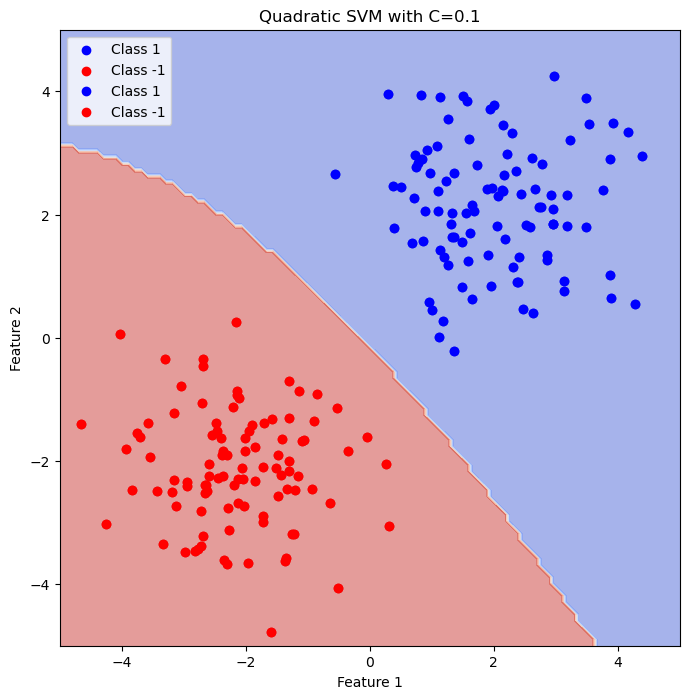

D:\Anaconda\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


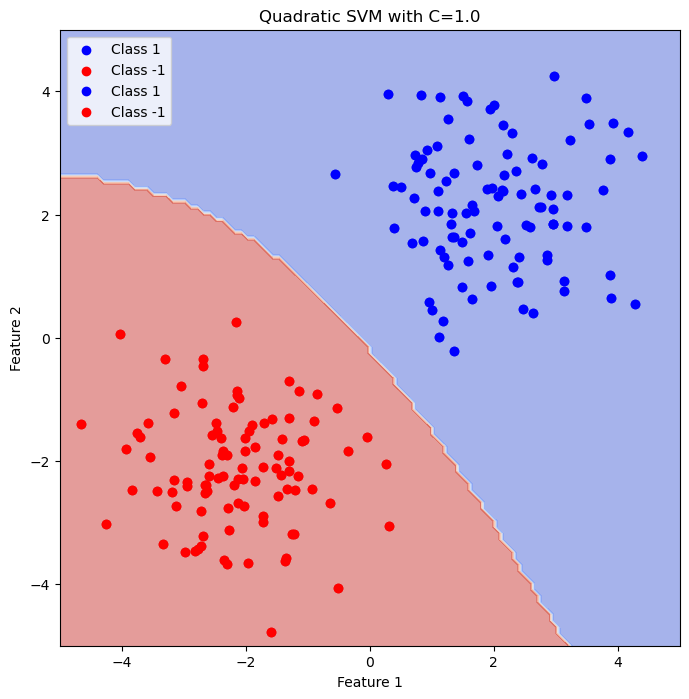

D:\Anaconda\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


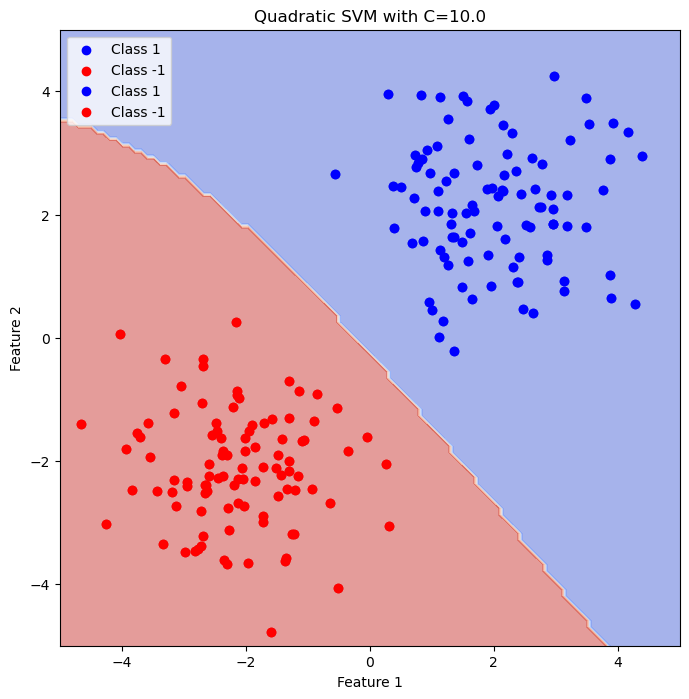

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures

# 假设 X_linear 和 y_linear 已经定义
# X_linear: 特征矩阵，形状为 (n_samples, n_features)
# y_linear: 标签向量，形状为 (n_samples,)

# 生成多项式特征
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_linear)

# 测试二次 SVM 并显示结果
def test_quadratic_svm(X, y, C):
    # 绘制数据集
    plt.figure(figsize=(8, 8))
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Class 1')
    plt.scatter(X[y == -1, 0], X[y == -1, 1], c='red', label='Class -1')
    
    # 训练线性 SVM 模型
    model = LinearSVC(C=C, max_iter=10000)
    model.fit(X_poly, y)

    # 获取模型参数
    w = model.coef_[0]
    b = model.intercept_[0]

    # 创建网格以绘制决策边界
    xx, yy = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
    Z = np.c_[xx.ravel(), yy.ravel()]
    Z_poly = poly.transform(Z)
    Z_pred = model.predict(Z_poly)
    Z_pred = Z_pred.reshape(xx.shape)

    # 检查预测结果的标签顺序
    if model.classes_[0] == 1:
        # 如果模型的类别 1 对应的是 1，那么直接使用预测结果
        pass
    else:
        # 如果模型的类别 1 对应的是 -1，那么反转预测结果
        Z_pred = -Z_pred

    # 绘制决策边界
    plt.contourf(xx, yy, Z_pred, alpha=0.5, cmap='coolwarm')

    # 绘制数据点
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Class 1')
    plt.scatter(X[y == -1, 0], X[y == -1, 1], c='red', label='Class -1')

    # 设置绘图范围
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)

    plt.title(f'Quadratic SVM with C={C}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

# 测试不同参数值 C 的分类器
Cs = [0.1, 1.0, 10.0]
for C in Cs:
    test_quadratic_svm(X_linear, y_linear, C)

# 3. Двойственный переход и Ядровой SVM

Задачу обучения линейного SVM, рассмотренную в предыдущем пункте принято называть _прямой_ оптимизационной задачей для SVM. Любая задача оптимизации с ограничениями имеет [_двойственную_ задачу Лагранжа](http://goo.gl/OujTPr), в которой оптимизируются _двойственные переменные_ (множители Лагранжа), соответствующие штрафу за нарушение ограничений, максимизируется нижняя оценка функционала прямой задачи. В случае задачи квадратичного программирования, решение двойственной задачи (значение оптимизируемого функционала) совпадает с оптимумом прямой задачи.

Подробнее можно почитать в [статье](./SMAIS11_SVM.pdf).

Двойственная задача для SVM имеет вид:
$$
\begin{gather}
    \sum_{n} \alpha_n - \frac{1}{2}\sum_{n}\sum_{n'} \alpha_{n}\alpha_{n'} y_{n}y_{n'} x_{n}^Tx_{n'} \to \max_{\alpha} \\
    \begin{aligned}
        \text{s.t. } \quad  
        & 0 \le \alpha_n \le C, \quad \forall n = 1, \dots, N \\
        & \sum_{n} \alpha_n y_n = 0
    \end{aligned}
\end{gather}
$$

Оптимизируется вектор из двойственных переменных $\alpha_n$, соответствующих объектам обучающей выборки. Объект $x_n$ является опорным, если $\alpha_n > 0$.

Предсказание вычисляется по следующему правилу:
$$\hat{y}(x) = \text{sign}\left(\sum_{n}\alpha_{n}y_{n}x^Tx_{n} + b\right).$$

Для предсказания необходимо оценить значение $b$. Известно, что для любого опорного объекта, который классифицируется безошибочно верно:
$$y_n = \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'} + b,$$
значит для любого такого объекта:
$$b = y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}.$$

В случае наличия ошибок классификации обучающей выборки, предлагается усреднять значение $b$ по всем опорным векторам:
$$b = \frac{1}{N_\text{SV}}\sum_{n \in \text{SV}}\left(y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}\right).$$
Интуиция здесь такова, что суммарные ошибки в положительную сторону примерно равны суммарным ошибкам в отрицательную сторону.

Другой вариант — отказаться от параметра $b$ и работать с моделью $f(x) = w^Tx$, добавив к вектору $x$ константный признак.

#### Неявное преобразование признаков
Отметим, что двойственная задача SVM содержит вектора признаков исключительно в виде скалярного произведения $x^Tx'$. Эта особенность позволяет производить неявное преобразование признакового пространства. Вместо вычисления функции $\phi(\boldsymbol x)$, которая может отображать исходные признаки в вектора очень большой размерности, будем вычислять скалярное произведение $k(\boldsymbol x, \boldsymbol x') = \phi(\boldsymbol x)^T\phi(\boldsymbol x')$ называемое _ядром_. 

#### Задание
  1. Реализуйте процедуру обучения ядрового SVM, используя QP-солвер.
  2. Протестируйте на случайных двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Попробуйте следующие ядровые функции:
    - линейная: $k(x, x') = x^Tx'$
    - полиномиальная: $k(x, x') = (x^Tx' + 1)^p$ с различными степенями $p = 2,3,\dots$
    - Гауссовская-RBF: $k(x, x') = \exp(-\frac{1}{2\gamma}\|x - x'\|^2)$
  3. Как ведет себя SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $p$?
  4. Как ведет себя SVM с RBF-ядром в зависимости от параметров $C$ и $\gamma$? Поварьируйте параметры $C$ и $\gamma$ по логарифмической сетке. Какие значения параметров ведут к переобучению, а какие — к слишком грубой модели?

In [69]:
import numpy as np
from cvxopt import matrix, solvers

#定义核函数
#线性核函数
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

#多项式核函数，参数 p 表示多项式的次数
def polynomial_kernel(x1, x2, p=2):
    return (1 + np.dot(x1, x2)) ** p

#径向基函数（RBF）核函数，参数 gamma 控制核函数的宽度
def rbf_kernel(x1, x2, gamma=0.1):
    return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)

class KernelSVM:
    def __init__(self, kernel='linear', C=1.0, gamma=None, degree=2):
        self.kernel = kernel
        self.C = C
        self.gamma = gamma
        self.degree = degree
        self.alpha = None
        self.support_vectors = None
        self.support_labels = None
        self.b = 0

    def _compute_kernel_matrix(self, X):
        if self.kernel == 'linear':
            K = np.dot(X, X.T)
        elif self.kernel == 'polynomial':
            K = (1 + np.dot(X, X.T)) ** self.degree
        elif self.kernel == 'rbf':
            if self.gamma is None:
                self.gamma = 1.0 / X.shape[1]
            K = np.zeros((X.shape[0], X.shape[0]))
            for i in range(X.shape[0]):
                for j in range(X.shape[0]):
                    K[i, j] = rbf_kernel(X[i], X[j], self.gamma)
        else:
            raise ValueError("Unsupported kernel type")
        return K

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Compute the kernel matrix
        K = self._compute_kernel_matrix(X)

        # Define the quadratic programming problem
        P = matrix(np.outer(y, y) * K)
        q = matrix(-np.ones(n_samples))
        A = matrix(y, (1, n_samples), tc='d')
        b = matrix(0.0)
        G = matrix(np.vstack((np.eye(n_samples) * -1, np.eye(n_samples))), tc='d')
        h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)), tc='d')

        # Solve the quadratic programming problem
        solution = solvers.qp(P, q, G, h, A, b)
        self.alpha = np.ravel(solution['x'])

        # Support vectors have non-zero Lagrange multipliers
        sv = self.alpha > 1e-5
        self.support_vectors = X[sv]
        self.support_labels = y[sv]
        self.alpha = self.alpha[sv]

        # Calculate the bias term b
        for i in range(len(self.support_vectors)):
            self.b += self.support_labels[i]
            self.b -= np.sum(self.alpha * self.support_labels * K[sv, i])
        self.b /= len(self.support_vectors)

    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            s = 0
            for alpha, sv_y, sv in zip(self.alpha, self.support_labels, self.support_vectors):
                if self.kernel == 'linear':
                    s += alpha * sv_y * np.dot(X[i], sv)
                elif self.kernel == 'polynomial':
                    s += alpha * sv_y * (1 + np.dot(X[i], sv)) ** self.degree
                elif self.kernel == 'rbf':
                    s += alpha * sv_y * rbf_kernel(X[i], sv, self.gamma)
            y_pred[i] = s
        return np.sign(y_pred + self.b)

    def decision_function(self, X):
        y_pred = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            s = 0
            for alpha, sv_y, sv in zip(self.alpha, self.support_labels, self.support_vectors):
                if self.kernel == 'linear':
                    s += alpha * sv_y * np.dot(X[i], sv)
                elif self.kernel == 'polynomial':
                    s += alpha * sv_y * (1 + np.dot(X[i], sv)) ** self.degree
                elif self.kernel == 'rbf':
                    s += alpha * sv_y * rbf_kernel(X[i], sv, self.gamma)
            y_pred[i] = s
        return y_pred + self.b

# 用法示例
if __name__ == "__main__":
    from sklearn.datasets import make_classification
    from sklearn.model_selection import train_test_split

    # 生成合成数据集
    X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=42)
    y[y == 0] = -1  # Convert labels to -1 and 1

    # 将数据集拆分为训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # 训练 SVM 模型
    svm = KernelSVM(kernel='rbf', C=1.0, gamma=0.1)
    svm.fit(X_train, y_train)

    # 做出预测
    y_pred = svm.predict(X_test)

    # 评估模型
    accuracy = np.mean(y_pred == y_test)
    print(f"Accuracy: {accuracy:.2f}")

     pcost       dcost       gap    pres   dres
 0: -1.2948e+01 -1.1257e+02  4e+02  2e+00  8e-16
 1: -8.4513e+00 -5.6926e+01  5e+01  3e-16  5e-16
 2: -1.2046e+01 -1.9807e+01  8e+00  2e-16  5e-16
 3: -1.4332e+01 -1.6512e+01  2e+00  2e-16  5e-16
 4: -1.4912e+01 -1.5586e+01  7e-01  2e-16  4e-16
 5: -1.5143e+01 -1.5280e+01  1e-01  3e-16  6e-16
 6: -1.5190e+01 -1.5208e+01  2e-02  4e-16  6e-16
 7: -1.5197e+01 -1.5198e+01  6e-04  4e-16  5e-16
 8: -1.5197e+01 -1.5197e+01  6e-06  3e-16  6e-16
Optimal solution found.
Accuracy: 0.97


     pcost       dcost       gap    pres   dres
 0: -1.5371e+01 -1.3547e+02  6e+02  2e+00  2e-15
 1: -8.9460e+00 -7.5010e+01  1e+02  3e-01  2e-15
 2: -5.0408e+00 -1.5691e+01  1e+01  2e-02  7e-15
 3: -6.5775e+00 -8.8119e+00  3e+00  4e-03  1e-15
 4: -7.0281e+00 -8.1020e+00  1e+00  1e-03  7e-16
 5: -7.3219e+00 -7.5965e+00  3e-01  2e-04  7e-16
 6: -7.4136e+00 -7.4389e+00  3e-02  2e-16  8e-16
 7: -7.4257e+00 -7.4261e+00  3e-04  2e-16  8e-16
 8: -7.4259e+00 -7.4259e+00  3e-06  2e-16  9e-16
Optimal solution found.
Linear Accuracy: 0.97


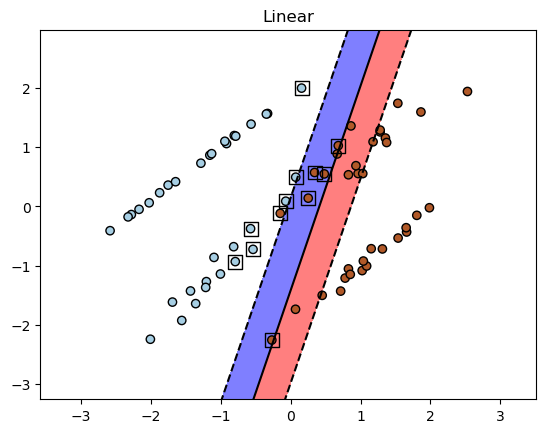

     pcost       dcost       gap    pres   dres
 0: -1.4912e+01 -1.3008e+02  6e+02  2e+00  1e-14
 1: -9.1655e+00 -7.0675e+01  1e+02  3e-01  6e-15
 2: -5.2947e+00 -1.9062e+01  2e+01  5e-02  4e-15
 3: -5.1296e+00 -8.2025e+00  4e+00  1e-02  2e-15
 4: -5.5652e+00 -6.1947e+00  8e-01  1e-03  1e-15
 5: -5.7206e+00 -5.8650e+00  2e-01  2e-04  2e-15
 6: -5.7695e+00 -5.7754e+00  7e-03  8e-06  3e-15
 7: -5.7719e+00 -5.7720e+00  7e-05  8e-08  2e-15
 8: -5.7720e+00 -5.7720e+00  7e-07  8e-10  2e-15
Optimal solution found.
Polynomial (p=2) Accuracy: 0.97


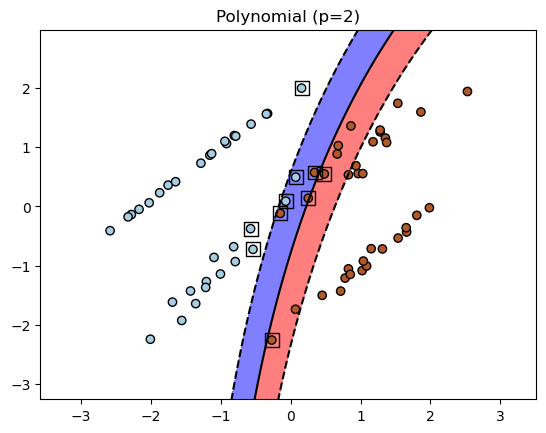

     pcost       dcost       gap    pres   dres
 0: -5.9035e+00 -9.5827e+01  4e+02  2e+00  2e-14
 1: -3.9071e+00 -3.9842e+01  5e+01  1e-01  9e-15
 2: -3.9056e+00 -1.3100e+01  1e+01  3e-02  5e-15
 3: -4.1791e+00 -8.4157e+00  5e+00  9e-03  3e-15
 4: -4.4280e+00 -5.2370e+00  1e+00  1e-03  4e-15
 5: -4.4984e+00 -4.5692e+00  7e-02  2e-16  3e-15
 6: -4.5289e+00 -4.5316e+00  3e-03  2e-16  3e-15
 7: -4.5304e+00 -4.5305e+00  7e-05  2e-16  3e-15
 8: -4.5305e+00 -4.5305e+00  1e-06  2e-16  3e-15
Optimal solution found.
Polynomial (p=3) Accuracy: 1.00


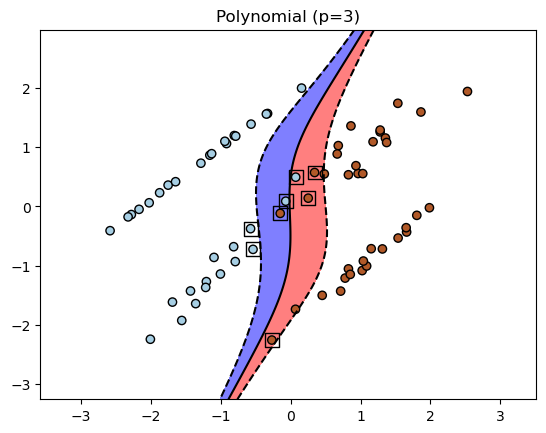

     pcost       dcost       gap    pres   dres
 0: -1.2948e+01 -1.1257e+02  4e+02  2e+00  8e-16
 1: -8.4513e+00 -5.6926e+01  5e+01  3e-16  5e-16
 2: -1.2046e+01 -1.9807e+01  8e+00  2e-16  5e-16
 3: -1.4332e+01 -1.6512e+01  2e+00  2e-16  5e-16
 4: -1.4912e+01 -1.5586e+01  7e-01  2e-16  4e-16
 5: -1.5143e+01 -1.5280e+01  1e-01  3e-16  6e-16
 6: -1.5190e+01 -1.5208e+01  2e-02  4e-16  6e-16
 7: -1.5197e+01 -1.5198e+01  6e-04  4e-16  5e-16
 8: -1.5197e+01 -1.5197e+01  6e-06  3e-16  6e-16
Optimal solution found.
RBF (gamma=0.1) Accuracy: 0.97


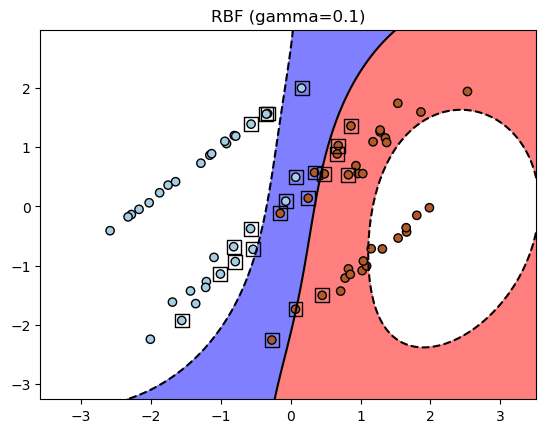

     pcost       dcost       gap    pres   dres
 0: -8.1221e+00 -1.0683e+02  4e+02  2e+00  5e-16
 1: -5.6411e+00 -5.2144e+01  5e+01  5e-16  5e-16
 2: -8.7149e+00 -1.5543e+01  7e+00  1e-16  6e-16
 3: -9.5723e+00 -1.1704e+01  2e+00  3e-16  4e-16
 4: -9.9244e+00 -1.0485e+01  6e-01  3e-16  3e-16
 5: -1.0038e+01 -1.0196e+01  2e-01  2e-16  4e-16
 6: -1.0071e+01 -1.0113e+01  4e-02  1e-16  6e-16
 7: -1.0082e+01 -1.0091e+01  9e-03  7e-16  4e-16
 8: -1.0085e+01 -1.0086e+01  5e-04  2e-16  2e-16
 9: -1.0085e+01 -1.0085e+01  2e-05  3e-16  3e-16
10: -1.0085e+01 -1.0085e+01  2e-07  7e-16  4e-16
Optimal solution found.
RBF (gamma=1.0) Accuracy: 1.00


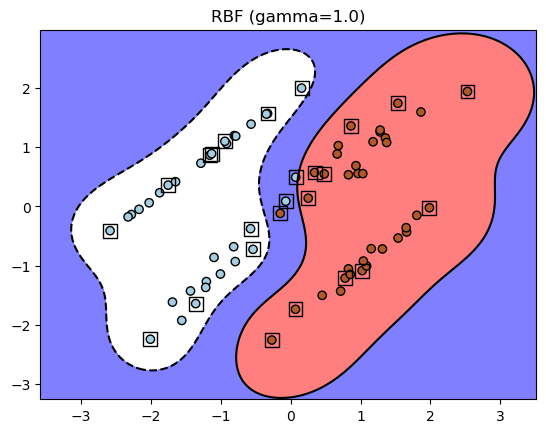

In [71]:

def plot_decision_boundary(svm, X, y, title):
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, levels=[-1, 0, 1], colors=['blue', 'red'], alpha=0.5)
    plt.contour(xx, yy, Z, levels=[-1, 0, 1], colors='k', linestyles=['--', '-', '--'])

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')
    plt.scatter(svm.support_vectors[:, 0], svm.support_vectors[:, 1], facecolors='none', edgecolors='k', s=100, marker='s')
    plt.title(title)
    plt.show()

# Example usage
if __name__ == "__main__":
    from sklearn.datasets import make_classification
    from sklearn.model_selection import train_test_split

    # Generate a synthetic dataset
    X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=42)
    y[y == 0] = -1  # Convert labels to -1 and 1

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Test different kernels
    kernels = [
        ('Linear', 'linear'),
        ('Polynomial (p=2)', 'polynomial', 2),
        ('Polynomial (p=3)', 'polynomial', 3),
        ('RBF (gamma=0.1)', 'rbf', 0.1),
        ('RBF (gamma=1.0)', 'rbf', 1.0)
    ]

    for name, kernel, *params in kernels:
        if kernel == 'polynomial':
            degree = params[0]
            svm = KernelSVM(kernel=kernel, C=1.0, degree=degree)
        elif kernel == 'rbf':
            gamma = params[0]
            svm = KernelSVM(kernel=kernel, C=1.0, gamma=gamma)
        else:
            svm = KernelSVM(kernel=kernel, C=1.0)

        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)
        accuracy = np.mean(y_pred == y_test)
        print(f"{name} Accuracy: {accuracy:.2f}")

        plot_decision_boundary(svm, X_train, y_train, name)

In [ ]:
3. Поведенческий анализ полиномиального ядра SVM.
Поведение полиномиального ядра SVM зависит от параметра C и степени p ядра:

Большее значение C заставит модель уделять больше внимания ошибке обучения, что может привести к переобучению.
Меньшее значение C заставит модель допускать больше ошибок обучения, что потенциально приведет к более плавной границе принятия решения.
Увеличение степени p полинома увеличит сложность модели и усложнит границу решения.

In [ ]:
4. Поведенческий анализ ядра RBF SVM.
Для ядра RBF SVM влияние параметров C и γ следующее:

Большие значения C также приведут к переоснащению.
Меньшие значения C делают модель более общей.
Большие значения γ сделают границу решения более локализованной, что может привести к переобучению.
Меньшие значения γ сделают границу решения более гладкой, но могут привести к недообучению.

# Примеры

Настройка вывода графиков [`Maplotlib`](http://matplotlib.org/) и импорт функций из модуля [`pylab`](http://wiki.scipy.org/PyLab).

In [39]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Визуальное решение задачи квадратичного программирования

На следующем рисунке наглядно показано решение задачи QP из задания 1. Оптимизируемая функция $f(\boldsymbol x)$ показана линиями уровня, область значений недопустимых ограничениями окрашена в серый цвет.

C:\Anaconda3\lib\site-packages\matplotlib\contour.py:902: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


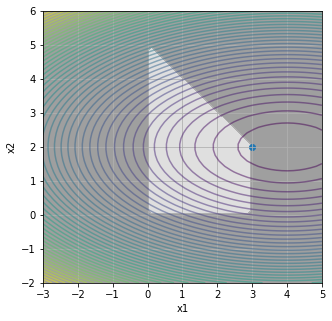

In [33]:
x1 = linspace(-3, 5, 50)
x2 = linspace(-2, 6, 50)
xx1, xx2 = meshgrid(x1, x2)

f = -8*xx1 - 16*xx2 + xx1**2 + 4*xx2**2
constr1 = (xx1 + xx2 <= 5)
constr2 = (0 <= xx1) & (xx1 <= 3)
constr3 = (xx2 >= 0)

figure(figsize=(5, 5))
grid(True)
xlabel('x1')
ylabel('x2')

contour(x1, x2, f, 50, alpha=0.5)
contourf(x1, x2, constr1 & constr2 & constr3, 1, alpha=0.5, linewidths=4, cmap='gray')
_ = scatter([3], [2])

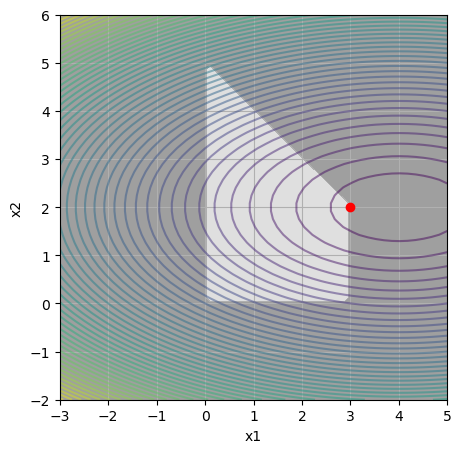

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# 定义网格
x1 = np.linspace(-3, 5, 50)
x2 = np.linspace(-2, 6, 50)
xx1, xx2 = np.meshgrid(x1, x2)

# 定义目标函数
f = -8 * xx1 - 16 * xx2 + xx1**2 + 4 * xx2**2

# 定义约束条件
constr1 = (xx1 + xx2 <= 5)
constr2 = (0 <= xx1) & (xx1 <= 3)
constr3 = (xx2 >= 0)

# 创建图形
plt.figure(figsize=(5, 5))
plt.grid(True)
plt.xlabel('x1')
plt.ylabel('x2')

# 绘制目标函数的等高线
plt.contour(x1, x2, f, 50, alpha=0.5)

# 绘制不可行区域
plt.contourf(x1, x2, constr1 & constr2 & constr3, 1, alpha=0.5, cmap='gray')

# 标记最优解点
plt.scatter([3], [2], color='red', zorder=10)

# 显示图形
plt.show()

In [26]:
np.array([True, False, False]) & np.array([True, False, True])

array([ True, False, False])

In [27]:
np.logical_and(np.array([True, False, False]), np.array([True, False, True]))

array([ True, False, False])

## Установка и использование `CvxOpt`

Библиотека [`cvxopt`](http://cvxopt.org/) может быть установлена как обычный python-пакет:

In [5]:
!pip install --upgrade --user cvxopt

  Using cached https://files.pythonhosted.org/packages/16/a0/0d090735e2639a74d6628831e02cc59284e3a3a4f5910f496fc6e435b645/cvxopt-1.2.5-cp36-cp36m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/56/39/537cb3e4e93f1ac5085dc3b3a43cfd99d0af9b29c44fcaa99490f526b611/mkl-2019.0-py2.py3-none-win_amd64.whl


Нас будет интересовать функция [`cvxopt.solvers.qp()`](http://cvxopt.org/examples/tutorial/qp.html):

In [ ]:
from cvxopt import solvers
?solvers.qp

## Пример работы с cvxopt

In [4]:
from cvxopt import matrix

A = matrix([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], (2,3))
print(A)
print(A.size)

[ 1.00e+00  3.00e+00  5.00e+00]
[ 2.00e+00  4.00e+00  6.00e+00]

(2, 3)


In [6]:
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],
            [0.0,-1.0,-3.0,5.0,4.0]])
print(G, G.size)

[-1.00e+00  0.00e+00]
[ 0.00e+00 -1.00e+00]
[-1.00e+00 -3.00e+00]
[ 2.00e+00  5.00e+00]
[ 3.00e+00  4.00e+00]
 (5, 2)


In [13]:
from cvxopt import solvers

# Define QP parameters (directly)
P = matrix([[1.0,0.0],[0.0,0.0]])
q = matrix([3.0,4.0])
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],[0.0,-1.0,-3.0,5.0,4.0]])
h = matrix([0.0,0.0,-15.0,100.0,80.0])
# Define QP parameters (with NumPy)
P = matrix(numpy.diag([1,0]), tc='d')
q = matrix(numpy.array([3,4]), tc='d')
G = matrix(numpy.array([[-1,0],[0,-1],[-1,-3],[2,5],[3,4]]), tc='d')
h = matrix(numpy.array([0,0,-15,100,80]), tc='d')
# Construct the QP, invoke solver
sol = solvers.qp(P,q,G,h)
# Extract optimal value and solution
print(sol['x']) # [7.13e-07, 5.00e+00]
print(sol['primal objective']) # 20.0000061731

     pcost       dcost       gap    pres   dres
 0:  1.0780e+02 -7.6366e+02  9e+02  4e-17  4e+01
 1:  9.3245e+01  9.7637e+00  8e+01  8e-17  3e+00
 2:  6.7311e+01  3.2553e+01  3e+01  8e-17  1e+00
 3:  2.6071e+01  1.5068e+01  1e+01  7e-17  7e-01
 4:  3.7092e+01  2.3152e+01  1e+01  1e-16  4e-01
 5:  2.5352e+01  1.8652e+01  7e+00  9e-17  4e-16
 6:  2.0062e+01  1.9974e+01  9e-02  7e-17  2e-16
 7:  2.0001e+01  2.0000e+01  9e-04  8e-17  2e-16
 8:  2.0000e+01  2.0000e+01  9e-06  1e-16  2e-16
Optimal solution found.
[ 7.13e-07]
[ 5.00e+00]

20.00000617311241


In [14]:
sol

{'x': <2x1 matrix, tc='d'>,
 'y': <0x1 matrix, tc='d'>,
 's': <5x1 matrix, tc='d'>,
 'z': <5x1 matrix, tc='d'>,
 'status': 'optimal',
 'gap': 8.788553731701274e-06,
 'relative gap': 4.3942774404993765e-07,
 'primal objective': 20.00000617311241,
 'dual objective': 19.99999738455868,
 'primal infeasibility': 1.1710307819972547e-16,
 'dual infeasibility': 1.9860273225978186e-16,
 'primal slack': 7.131816408857108e-07,
 'dual slack': 1.50695110360481e-08,
 'iterations': 8}

In [19]:
print(sol['x'])

[ 7.13e-07]
[ 5.00e+00]



Матрицы задач квадратичного программирования как правило разрежены, лучше использовать матричные операции над разреженными матрицами при реализации SVM.
[Разреженные и плотные матрицы](http://abel.ee.ucla.edu/cvxopt/userguide/matrices.html)

## Генерация случайной выборки для задачи классификации

В `SciKit-Learn` есть функция генерации случайных выборок для классификации [`sklearn.datasets.make_classification()`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Для того чтобы выборки не менялись при перезапуске ноутбука, используйте параметр `random_state`.

In [7]:
from sklearn.datasets import make_classification

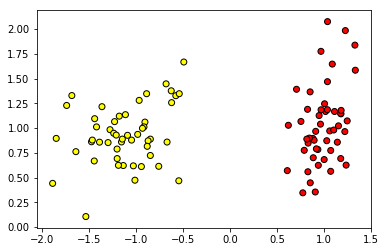

In [10]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=1)
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')

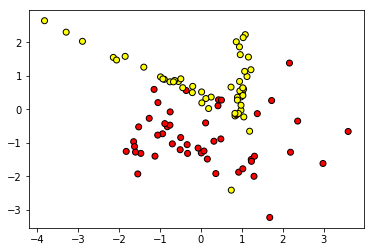

In [11]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=2, random_state=2)
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')

## Визуализация решающего правила

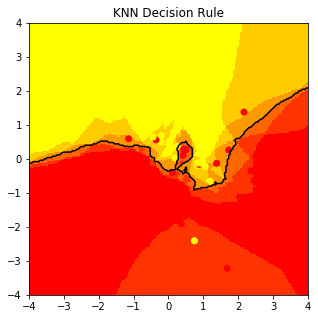

In [12]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X, y)

figure(figsize=(5, 5))
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')

xvals = linspace(-4, 4, 200)
yvals = linspace(-4, 4, 200)

xx, yy = np.meshgrid(xvals, yvals)
zz = np.reshape(model.predict_proba(c_[xx.ravel(), yy.ravel()])[:, 1], xx.shape)

# Цветной фон, соответствующий значению решающего правила
pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

# Линия уровня, соответствующая значению 0.5
contour(xx, yy, zz, levels=(0.5,), colors='k', linewidths=1.5, zorder=1)

xlim([-4, 4])
ylim([-4, 4])
_ = title('KNN Decision Rule')

## Реализация собственной модели для SciKit-Learn

В заданиях 2 и 3 требуется самостоятельно реализовать алгоритм обучения классификатора. Для того чтобы ваш алгоритм можно было использовать различными компонентами библиотеки SciKit-Learn (оценка качества, подбор параметров, композиции и т.д.) нужно всего лишь [реализовать интерфейс `BaseEstimator`](http://scikit-learn.org/stable/developers/#estimators).

In [13]:
from sklearn.base import BaseEstimator

class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform
        
    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        dim = X.shape[1]
        self.weights_ = empty(dim)
        self.bias_ = 0
        raise NotImplementedError() 
        
    def predict_proba(self, X):
        return (dot(X, self.weights_) + self.bias_).flatten()
            
    def predict(self, X):
        return sign(self.predict_proba(X))

In [ ]:
from sklearn.base import BaseEstimator

class DualSVM(BaseEstimator):
    def __init__(self, C, kernel=None):
        self.C = C
        self.kernel = kernel
        
    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        self.dim = X.shape[1]
        self.N = X.shape[0]
        self.alpha_ = empty(self.N)
        self.bias_ = 0
        raise NotImplementedError() 
        
    def predict_proba(self, X):
        pass
            
    def predict(self, X):
        pass